In [1]:
import os
import json
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim

import datasets, models
from models.poi_baselines import sum_of_differences, get_trace_offset
from models.template_attack import TemplateAttacker
from train.weird_gan import GANTrainer as Trainer
from datasets.google_tinyaes import GoogleTinyAES as Dataset
from models.gans.dcgan import DCGAN__Generator as Generator, DCGAN__Discriminator as Discriminator

Trial dir: ../results/noise_adder_gan__revised2/trial_40
Computing per-key means ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:24<00:00, 621.37it/s]


Computing sums of differences ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 246320.69it/s]


Computing signal-to-noise ratios ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:22<00:00, 632.29it/s]


Computing trace offsets ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:28<00:00, 594.60it/s]



Trial dir: ../results/noise_adder_gan__revised2/trial_41
Computing per-key means ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:23<00:00, 629.43it/s]


Computing sums of differences ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 236291.88it/s]


Computing signal-to-noise ratios ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:23<00:00, 628.35it/s]


Computing trace offsets ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:28<00:00, 593.77it/s]



Trial dir: ../results/noise_adder_gan__revised2/trial_87
Computing per-key means ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:23<00:00, 626.97it/s]


Computing sums of differences ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 236002.88it/s]


Computing signal-to-noise ratios ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:23<00:00, 626.84it/s]


Computing trace offsets ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [01:28<00:00, 592.97it/s]



Trial dir: None
Computing per-key means ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [00:26<00:00, 1988.56it/s]


Computing sums of differences ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 231723.03it/s]


Computing signal-to-noise ratios ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [00:26<00:00, 2006.33it/s]


Computing trace offsets ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52429/52429 [00:30<00:00, 1695.84it/s]


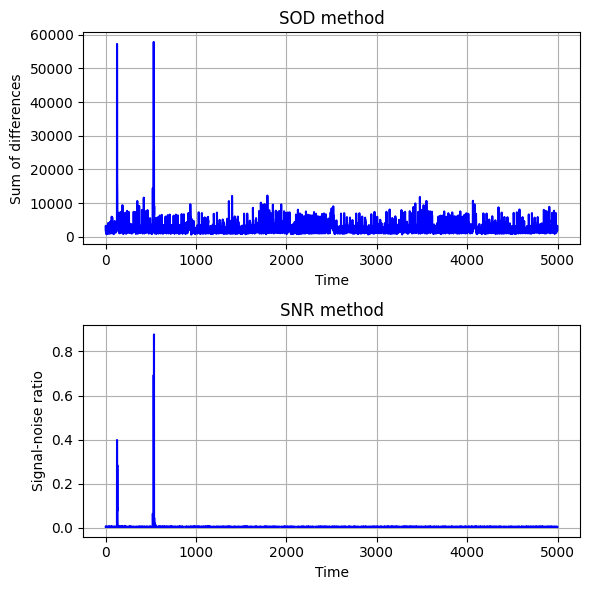

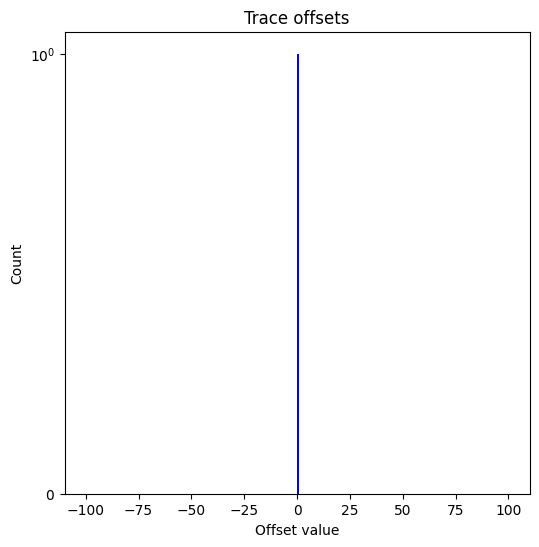

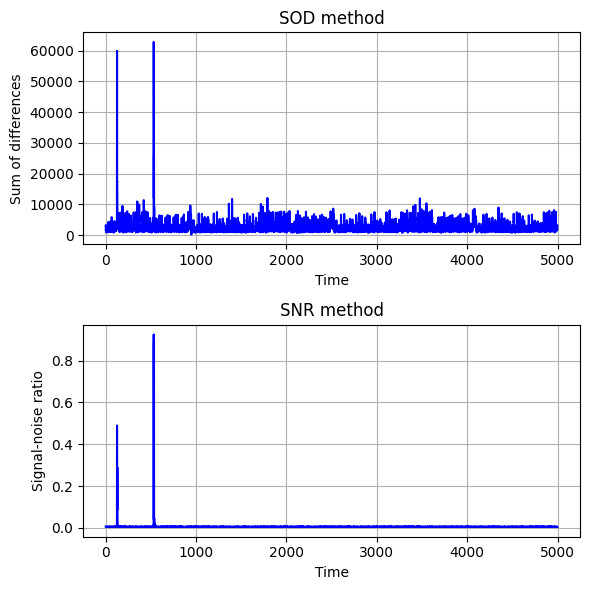

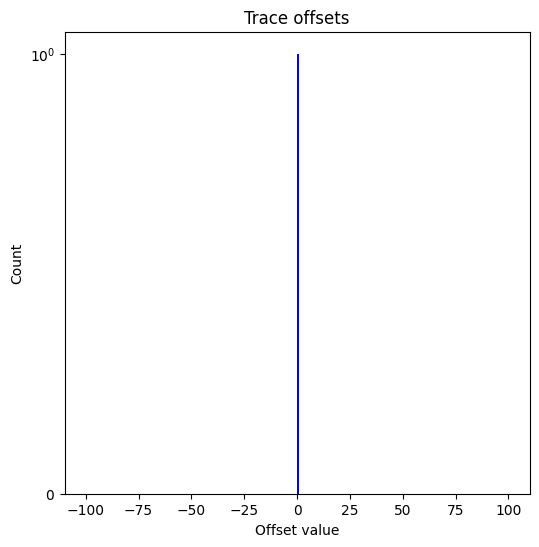

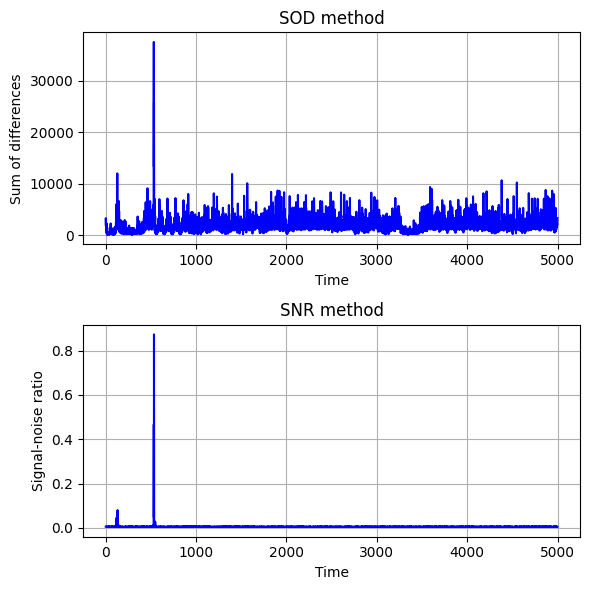

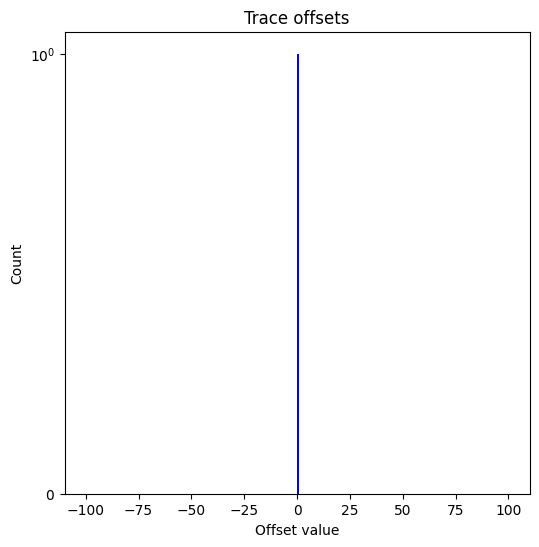

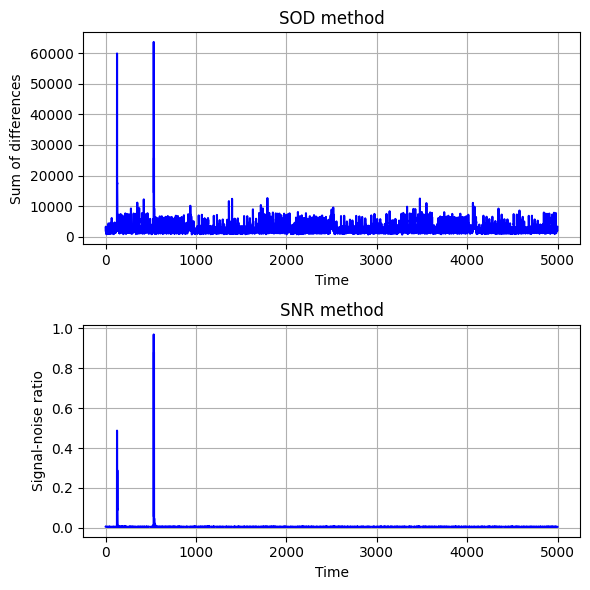

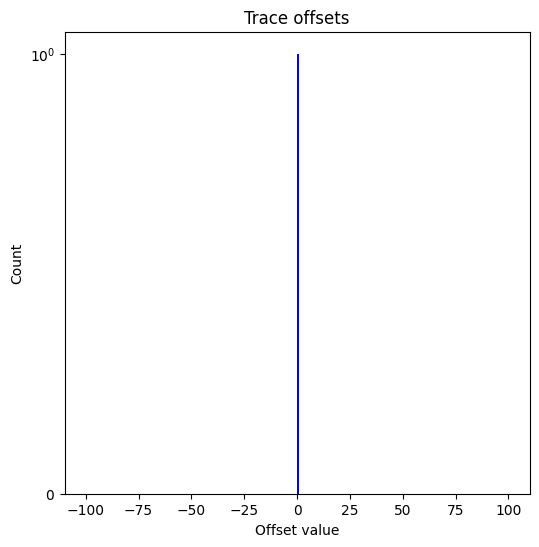

In [2]:
from train.analyze_dataset import DatasetAnalyzer
for trial_dir in ['trial_40', 'trial_41', 'trial_87', None]:
    if trial_dir is not None:
        trial_dir = os.path.join('..', 'results', 'noise_adder_gan__revised2', trial_dir)
    print('Trial dir:', trial_dir)
    dataset_analyzer = DatasetAnalyzer(
        dataset_name='GoogleTinyAES',
        trial_dir=trial_dir
    )
    dataset_analyzer()
    print()

In [3]:
base_path = os.path.join('..', 'results', 'noise_adder_gan__revised2')
trial_dirs = [f for f in os.listdir(base_path) if f.split('_')[0] == 'trial']
print(trial_dirs)
pert_decays = []
for trial_dir in trial_dirs:
    with open(os.path.join(base_path, trial_dir, 'settings.json'), 'r') as F:
        settings = json.load(F)
    pert_decays.append(settings['pert_decay'])
sorted_indices = np.argsort(pert_decays)
trial_dirs = [trial_dirs[idx] for idx in sorted_indices]
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

['trial_87', 'trial_40', 'trial_41']


In [4]:
class TrialAnalyzer:
    def __init__(self, trial_dir, device):
        self.trial_dir = trial_dir
        self.device = device
        
        with open(os.path.join(base_path, trial_dir, 'settings.json'), 'r') as F:
            settings = json.load(F)
        settings['device'] = device
        settings['batch_size'] = 64
        self.settings = settings
        trainer = Trainer(**settings)
        self.trainer = trainer
        trainer.reset()
        self.generator = trainer.generator
        self.train_dataset = trainer.train_dataset
        self.train_dataloader = trainer.train_dataloader
        self.val_dataloader = trainer.val_dataloader
        self.cal_dataloader = trainer.cal_dataloader
        self.test_dataloader = trainer.test_dataloader
        checkpoint = torch.load(
            os.path.join(base_path, trial_dir, 'models', 'training_checkpoint.pt'),
            map_location=device
        )
        self.generator.load_state_dict(checkpoint['generator_state'])
        self.classifier_name = trainer.classifier_name
        self.classifier_kwargs = trainer.classifier_kwargs
        self.classifier_optimizer = getattr(optim, trainer.classifier_optimizer_class)
        self.classifier_optimizer_kwargs = trainer.classifier_optimizer_kwargs
    
    def plot_trace_alignment(self, axes=None, num_examples=5, max_offset=50, ax_width=5):
        if axes is None:
            _, axes = plt.subplots(num_examples, 3, figsize=(ax_width*3, ax_width*num_examples))
        for ax1, ax2, ax3 in axes:
            idx1, idx2 = (np.random.randint(len(self.train_dataset)) for _ in range(2))
            x1, _ = self.train_dataset[idx1]
            x2, _ = self.train_dataset[idx2]
            x1, x2 = x1.squeeze().numpy(), x2.squeeze().numpy()
            offset, corr = get_trace_offset(x1, x2, max_offset=max_offset)
            ax1.plot(x1, color='red', label='ref')
            ax1.plot(x2, color='blue', label='trace')
            tax1 = ax1.twinx()
            tax1.plot(np.abs(x1 - x2), linestyle='none', marker='.', markersize=1, color='black', label='diff')
            x1a, x2a = x1[max_offset:-max_offset], x2[max_offset-offset:-(max_offset+offset)]
            print(offset, get_trace_offset(x1a, x2a, max_offset=max_offset)[0])
            ax2.plot(x1a, color='red', label='ref')
            ax2.plot(x2a, color='blue', label='trace')
            tax2 = ax2.twinx()
            tax2.plot(np.abs(x1a - x2a), linestyle='none', marker='.', markersize=1, color='black', label='diff')
            ax1.legend()
            ax2.legend()
            tax1.legend()
            tax2.legend()
            ax3.plot(corr, color='blue')
    
    def plot_sum_of_differences(self, ax=None):
        sum_diffs = sum_of_differences(self.train_dataset)
        samples = np.arange(len(sum_diffs))
        
        if ax is None:
            (_, ax) = plt.subplots()
        ax.set_xlabel('Sample')
        ax.set_ylabel('Sum of differences')
        ax.plot(samples, sum_diffs, '.', color='blue')
        ax.set_yscale('log')
        ax.grid(True)
        
        smooth_radius = 50
        smoothed_mean = np.array([
            np.mean(sum_diffs[max(0, idx-smooth_radius):min(idx+smooth_radius+1, len(sum_diffs))]) for idx in range(len(sum_diffs))
        ])
        ax.plot(samples, smoothed_mean, '--', color='red')
    
    def lr_finder(self, min_lr=1e-6, max_lr=1e-1, num_samples=100, ax=None):
        lr_values = 10**np.linspace(np.log10(min_lr), np.log10(max_lr), num_samples)
        loss_values = []
        for lr in tqdm(lr_values):
            classifier = models.construct_model(self.classifier_name, input_shape=self.train_dataloader.dataset.dataset.data_shape, **self.classifier_kwargs)
            classifier = classifier.to(self.device)
            self.classifier_optimizer_kwargs['lr'] = lr
            classifier_opt = self.classifier_optimizer(classifier.parameters(), **self.classifier_optimizer_kwargs)
            for batch in self.train_dataloader:
                traces, labels = datasets.common.unpack_batch(batch, self.device)
                with torch.no_grad():
                    gen_logits = self.generator(traces)
                    mask = torch.heaviside(gen_logits, torch.zeros_like(gen_logits))
                    traces = mask*torch.randn_like(traces) + (1-mask)*traces
                logits = classifier(traces)
                loss = nn.functional.cross_entropy(logits, labels)
                classifier_opt.zero_grad()
                loss.backward()
                classifier_opt.step()
            with torch.no_grad():
                losses = []
                for batch in self.val_dataloader:
                    traces, labels = datasets.common.unpack_batch(batch, self.device)
                    gen_logits = self.generator(traces)
                    mask = torch.heaviside(gen_logits, torch.zeros_like(gen_logits))
                    traces = mask*torch.randn_like(traces) + (1-mask)*traces
                    logits = classifier(traces)
                    loss = nn.functional.cross_entropy(logits, labels)
                    losses.append(loss.item())
                loss_values.append(np.mean(losses))
        
        if ax is None:
            (_, ax) = plt.subplots()
        ax.set_xlabel('Learning rate')
        ax.set_ylabel('Val loss after 1 epoch')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(lr_values, loss_values, color='blue')
        
    @torch.no_grad()
    def plot_mask_stats(self, dataloader, input_shape=(5000,), ax=None, color='blue'):
        mean, stdev = (np.zeros(input_shape, dtype=float) for _ in range(2))        
        for bidx, batch in enumerate(tqdm(dataloader)):
            traces, _ = datasets.common.unpack_batch(batch, self.device)
            logits = self.generator(traces)
            #mask = nn.functional.sigmoid(logits)
            mask = torch.heaviside(logits, torch.zeros_like(logits))
            mask = mask.detach().squeeze().cpu().numpy()
            mask_mean = np.mean(mask, axis=0)
            mask_stdev = np.std(mask, axis=0)
            mask_min = np.min(mask, axis=0)
            mask_max = np.max(mask, axis=0)
            mean = (bidx/(bidx+1))*mean + (1/(bidx+1))*mask_mean
            stdev = (bidx/(bidx+1))*stdev + (1/(bidx+1))*mask_stdev
        
        if ax is None:
            (_, ax) = plt.subplots()
        #ax.set_title('Mask magnitude over time:\npert_metric={},\npert_decay={},\ncal_temp={},\nadv_loss={}'.format(self.settings['pert_metric'], self.settings['pert_decay'], self.settings['cal_temperature'], self.settings['adv_loss']))
        ax.set_xlabel('Sample number')
        ax.set_ylabel('Proportion')
        samples = np.arange(len(mean))
        ax.plot(samples, mean, '.', color=color)
        ax.grid(True)
        
        smooth_radius = 50
        smoothed_mean = np.array([
            np.mean(mean[max(0, idx-smooth_radius):min(idx+smooth_radius+1, len(mean))]) for idx in range(len(mean))
        ])
        ax.plot(samples, smoothed_mean, '--', color='red')
        
    @torch.no_grad()
    def plot_histogram(self, dataloader, ax=None, num_bins=100):
        hist = np.zeros((num_bins,), dtype=float)
        thresh_hist = np.zeros((num_bins,), dtype=float)
        for batch in tqdm(dataloader):
            traces, _ = datasets.common.unpack_batch(batch, self.device)
            logits = self.generator(traces)
            mask = nn.functional.sigmoid(logits)
            mask = mask.detach().cpu().numpy()
            batch_hist, batch_edges = np.histogram(mask, bins=num_bins, range=(0.0, 1.0))
            hist += batch_hist
            
            thresh_mask = torch.heaviside(logits, torch.zeros_like(logits))
            thresh_mask = thresh_mask.detach().cpu().numpy()
            batch_thresh_hist, _ = np.histogram(thresh_mask, bins=num_bins, range=(0.0, 1.0))
            thresh_hist += batch_thresh_hist
            
        hist /= np.sum(hist)
        thresh_hist /= np.sum(thresh_hist)
        #hist = np.cumsum(hist)
        
        if ax is None:
            (_, ax) = plt.subplots()
        ax.set_title('Mask magnitude distribution:\npert_metric={},\npert_decay={},\ncal_temp={},\nadv_loss={}'.format(self.settings['pert_metric'], self.settings['pert_decay'], self.settings['cal_temperature'], self.settings['adv_loss']))
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Proportion')
        ax.bar(batch_edges[:-1], hist, width=batch_edges[1:]-batch_edges[:-1], align='edge', color='blue')
        tax = ax.twinx()
        tax.bar(batch_edges[:-1], thresh_hist, width=5*(batch_edges[1:]-batch_edges[:-1]), align='edge', color='red', alpha=0.5)
        ax.set_yscale('log')
        tax.set_yscale('log')
        tax.set_ylim(*ax.get_ylim())

def subplots():
    rows = int(np.sqrt(len(trial_dirs)))
    cols = int(np.ceil(len(trial_dirs)/rows))
    (fig, axes) = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), sharex=True, sharey=True)
    if hasattr(axes, '__iter__'):
        axes = axes.flatten()
    else:
        axes = [axes]
    return fig, axes

In [5]:
trial_analyzer = TrialAnalyzer(trial_dirs[0], device)
trial_analyzer.plot_trace_alignment(num_examples=20)

-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
-21 0
Error in callback <function flush_figures at 0x7f1eb8a170d0> (for post_execute):


KeyboardInterrupt: 

In [6]:
trial_analyzer = TrialAnalyzer(trial_dirs[0], device)
sum_diffs = sum_of_differences(trial_analyzer.train_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117709/117709 [00:27<00:00, 4240.58it/s]


In [7]:
accuracies = []

for samples_to_use in tqdm(range(1, 51)):
    template_attacker = TemplateAttacker(trial_analyzer.train_dataset, sum_diffs.squeeze(), samples_to_use=samples_to_use)
    template_attacker.to(device)
    trial_analyzer.trainer.classifier = template_attacker
    rv = trial_analyzer.trainer.eval_epoch(trial_analyzer.val_dataloader, posttrain=True)
    accuracies.append(rv['classifier_acc'])

fig, ax = plt.subplots()
ax.plot(accuracies, color='blue')

 63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 8290/13107 [00:04<00:02, 1867.33it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13107/13107 [00:06<00:00, 1872.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 220671.53it/s]

 25%|███████████████████████████████▎                                                                                               | 3231/13107 [00:01<00:05, 1868.78it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 11982/13107 [00:06<00:00, 1907.11it/s]


 56%|███████████████████████████████████████████████████████████████████████                                                        | 7335/13107 [00:03<00:03, 1872.69it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13107/13107 [00:07<00:00, 1872.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 237640.30it/s]

 18%|██████████████████████▎                                                                                                        | 2298/13107 [00:01<00:05, 1905.68it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 11093/13107 [00:05<00:01, 1905.48it/s]


 50%|██████████████████████████████████████████████████████████████▉                                                                | 6492/13107 [00:03<00:03, 1905.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13107/13107 [00:06<00:00, 1901.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65280/65280 [00:00<00:00, 236449.01it/s]

 12%|███████████████                                                                                                                | 1556/13107 [00:00<00:05, 1929.41it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                         | 10507/13107 [00:05<00:01, 1921.43it/s]


  6%|████████                                                                                                                               | 3/50 [03:26<53:58, 68.90s/it]

KeyboardInterrupt



In [ ]:
trial_analyzer = TrialAnalyzer(trial_dirs[0], device)
trial_analyzer.plot_sum_of_differences()

In [ ]:
fig, axes = subplots()
axes[0].set_ylim(1e-5, 2e0)

for trial_dir, ax in zip(trial_dirs, axes):
    trial_analyzer = TrialAnalyzer(trial_dir, device)
    trial_analyzer.plot_histogram(trial_analyzer.val_dataloader, ax=ax)

plt.tight_layout()

In [ ]:
fig, axes = subplots()

for trial_dir, ax in zip(trial_dirs, axes):
    trial_analyzer = TrialAnalyzer(trial_dir, device)
    trial_analyzer.plot_mask_stats(trial_analyzer.val_dataloader, ax=ax)
plt.tight_layout()

In [ ]:
fig, axes = subplots()

for trial_dir, ax in zip(trial_dirs, axes):
    trial_analyzer = TrialAnalyzer(trial_dir, device)
    trial_analyzer.lr_finder(ax=ax)

plt.tight_layout()